#Install Libraries

In [1]:
#NLTK libraries to remove stopwords, for lemmatization and tokenizing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [3]:
from tabulate import tabulate

In [4]:
from wordcloud import WordCloud, STOPWORDS

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [6]:
from scipy import stats

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [8]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [9]:
import gensim
from gensim.models import Word2Vec

#Load Data

In [15]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
#Loading the training set
train_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/sadness/train_sadness.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [17]:
#Loading the development set
dev_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/sadness/dev_sadness_intensity.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [18]:
#Loading the test set
test_read=pd.read_csv("/content/gdrive/MyDrive/EmoInt/sadness/test_sadness_intensity.txt",delimiter = "\t",names=["Index", "Tweet", "Emotion", "Emotion Intensity"])

In [19]:
#Display the training data for anger 
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,40000,Depression sucks! #depression,sadness,0.958
1,40001,Feeling worthless as always #depression,sadness,0.958
2,40002,Feeling worthless as always,sadness,0.958
3,40003,My #Fibromyalgia has been really bad lately wh...,sadness,0.946
4,40004,Im think ima lay in bed all day and sulk. Life...,sadness,0.934


In [20]:
#Display the development data for anger 
dev_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,40786,@1johndes ball watching &amp; Rojo'd header wa...,sadness,0.583
1,40787,"A pessimist is someone who, when opportunity k...",sadness,0.188
2,40788,A .500 season is all I'm looking for at this p...,sadness,0.688
3,40789,"Stars, when you shine,\nYou know how I feel.\n...",sadness,0.292
4,40790,All I want to do is watch some netflix but I a...,sadness,0.667


In [21]:
#Display the test data for anger 
test_read.head()

,Index,Tweet,Emotion,Emotion Intensity
0,40860,My 2 teens sons just left in the car to get ha...,sadness,0.667
1,40861,My 2 teens sons just left in the car to get ha...,sadness,0.458
2,40862,HartRamsey'sUPLIFT If you're still discouraged...,sadness,0.396
3,40863,@AmontanaW I nearly dropped my phone into the ...,sadness,0.271
4,40864,Whenever I'm feeling sad I will listen to mons...,sadness,0.604


#Data Analysis

In [22]:
#Length of training set
train_read.shape[0]

786

In [23]:
#Length of development set
dev_read.shape[0]

74

In [24]:
#Length of test set
test_read.shape[0]

673

In [25]:
#Data type of each column in training set
train_read.dtypes

Index                  int64
Tweet                 object
Emotion               object
Emotion Intensity    float64
dtype: object

In [26]:
#Converting tweet and emotion from object to string type
train_read.astype({'Tweet':'string', 'Emotion':'string'}).dtypes

Index                  int64
Tweet                 string
Emotion               string
Emotion Intensity    float64
dtype: object

In [27]:
#Describe the dataset
train_read.describe()

,Index,Emotion Intensity
count,786.000000,786.000000
mean,40392.500000,0.495957
std,227.042947,0.190841
min,40000.000000,0.083000
25%,40196.250000,0.351750
50%,40392.500000,0.479000
75%,40588.750000,0.646000
max,40785.000000,0.958000


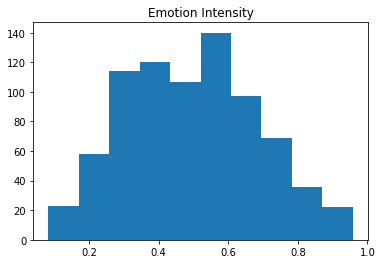

In [28]:
hist = train_read.hist(column='Emotion Intensity',grid=False)

#Text Cleaning

## Converting to Lower Case

In [29]:
train_read['Cleaned Text']=train_read['Tweet'].str.lower()

In [30]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text
0,40000,Depression sucks! #depression,sadness,0.958,depression sucks! #depression
1,40001,Feeling worthless as always #depression,sadness,0.958,feeling worthless as always #depression
2,40002,Feeling worthless as always,sadness,0.958,feeling worthless as always
3,40003,My #Fibromyalgia has been really bad lately wh...,sadness,0.946,my #fibromyalgia has been really bad lately wh...
4,40004,Im think ima lay in bed all day and sulk. Life...,sadness,0.934,im think ima lay in bed all day and sulk. life...


In [31]:
dev_read['Cleaned Text']=dev_read['Tweet'].str.lower()

In [32]:
test_read['Cleaned Text']=test_read['Tweet'].str.lower()

## Removing Numbers

In [33]:
train_read['Tweet'][33]

"@xBFDR yeah I'm sure it will, it's just so depressing having to talk to my parents over the phone instead of talking to them downstairs"

In [34]:
train_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

In [35]:
train_read['Cleaned Text'][33]

"@xbfdr yeah i'm sure it will, it's just so depressing having to talk to my parents over the phone instead of talking to them downstairs"

In [36]:
dev_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

In [37]:
test_read['Cleaned Text'].replace('\d+', '', regex=True, inplace=True)

## Removing URLs

In [38]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

In [39]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

In [40]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

## Separating Hashtags

In [41]:
train_read['Tweet'][3]

'My #Fibromyalgia has been really bad lately which is not good for my mental state. I feel very overwhelmed #anxiety #bipolar #depression'

In [42]:
def separating_hashtags(text):
  return re.findall("#([a-zA-Z0-9_]{1,50})", text)

In [43]:
def removing_hashtags(text):
  return re.sub("#[A-Za-z0-9_]+","", text)

In [44]:
train_read['Hashtags'] = train_read['Tweet'].apply(separating_hashtags)
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(removing_hashtags)

In [45]:
train_read['Cleaned Text'][3]

'my  has been really bad lately which is not good for my mental state. i feel very overwhelmed   '

In [46]:
train_read['Hashtags'][3]

['Fibromyalgia', 'anxiety', 'bipolar', 'depression']

In [47]:
dev_read['Hashtags'] = dev_read['Tweet'].apply(separating_hashtags)
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(removing_hashtags)

In [48]:
test_read['Hashtags'] = test_read['Tweet'].apply(separating_hashtags)
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(removing_hashtags)

## Removing UserHandles




In [49]:
train_read['Tweet'][16]

"We can't even grieve over one black body before another one pops up due to pig brutality"

In [50]:
def removeUserHandles(text):
  return re.sub("@[A-Za-z0-9_]+","", text)

In [51]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(removeUserHandles)

In [52]:
train_read['Cleaned Text'][16]

"we can't even grieve over one black body before another one pops up due to pig brutality"

In [53]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(removeUserHandles)

In [54]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(removeUserHandles)

##Removing Special Characters

In [55]:
train_read['Tweet'][27]

'When you have 15 doe run the opposite side of you ðŸ™\x81 #depression'

In [56]:
def remove_specialCharacters(text):
  return re.sub(r"[^\*a-zA-Z0-9]"," ",text)

In [57]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(remove_specialCharacters)

In [58]:
train_read['Cleaned Text'][27]

'when you have  doe run the opposite side of you      '

In [59]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(remove_specialCharacters)

In [60]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(remove_specialCharacters)

## Tokenizing

In [61]:
def tokenize(text):
  return word_tokenize(text)

In [62]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(tokenize)

In [63]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,40000,Depression sucks! #depression,sadness,0.958,"[depression, sucks]",[depression]
1,40001,Feeling worthless as always #depression,sadness,0.958,"[feeling, worthless, as, always]",[depression]
2,40002,Feeling worthless as always,sadness,0.958,"[feeling, worthless, as, always]",[]
3,40003,My #Fibromyalgia has been really bad lately wh...,sadness,0.946,"[my, has, been, really, bad, lately, which, is...","[Fibromyalgia, anxiety, bipolar, depression]"
4,40004,Im think ima lay in bed all day and sulk. Life...,sadness,0.934,"[im, think, ima, lay, in, bed, all, day, and, ...",[]


In [64]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(tokenize)

In [65]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(tokenize)

## Remove Stopwords

In [66]:
stop_words = set(stopwords.words('english'))

In [67]:
def remove_stopwords(word_list):
  return [word for word in word_list if word not in stopwords.words('english')]

In [68]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(remove_stopwords)

In [69]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,40000,Depression sucks! #depression,sadness,0.958,"[depression, sucks]",[depression]
1,40001,Feeling worthless as always #depression,sadness,0.958,"[feeling, worthless, always]",[depression]
2,40002,Feeling worthless as always,sadness,0.958,"[feeling, worthless, always]",[]
3,40003,My #Fibromyalgia has been really bad lately wh...,sadness,0.946,"[really, bad, lately, good, mental, state, fee...","[Fibromyalgia, anxiety, bipolar, depression]"
4,40004,Im think ima lay in bed all day and sulk. Life...,sadness,0.934,"[im, think, ima, lay, bed, day, sulk, life, hi...",[]


In [70]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(remove_stopwords)

In [71]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(remove_stopwords)

##Lemmatization

In [72]:
lemmatizer = WordNetLemmatizer()

In [73]:
def lemmatize(word_list):
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w, pos = "v") for w in word_list])
  return nltk.word_tokenize(lemmatized_output)

In [74]:
train_read['Cleaned Text'] = train_read['Cleaned Text'].apply(lemmatize)

In [75]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags
0,40000,Depression sucks! #depression,sadness,0.958,"[depression, suck]",[depression]
1,40001,Feeling worthless as always #depression,sadness,0.958,"[feel, worthless, always]",[depression]
2,40002,Feeling worthless as always,sadness,0.958,"[feel, worthless, always]",[]
3,40003,My #Fibromyalgia has been really bad lately wh...,sadness,0.946,"[really, bad, lately, good, mental, state, fee...","[Fibromyalgia, anxiety, bipolar, depression]"
4,40004,Im think ima lay in bed all day and sulk. Life...,sadness,0.934,"[im, think, ima, lay, bed, day, sulk, life, hi...",[]


In [76]:
dev_read['Cleaned Text'] = dev_read['Cleaned Text'].apply(lemmatize)

In [77]:
test_read['Cleaned Text'] = test_read['Cleaned Text'].apply(lemmatize)

## Word Cloud

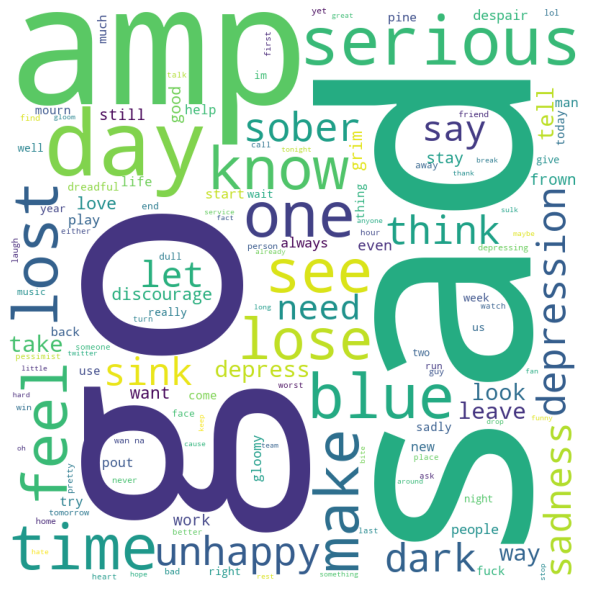

In [78]:
comment_words = ''
for val in train_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in train_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [79]:
#Unique words in Train set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
max_words=len(np.unique(x))

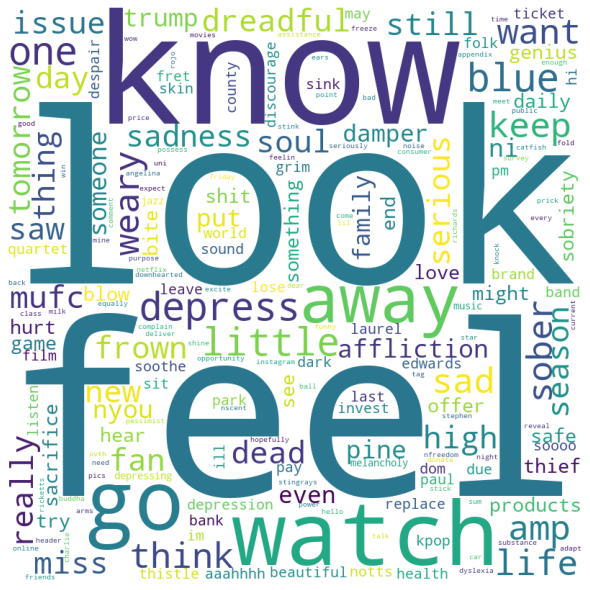

In [80]:
comment_words = ''
for val in dev_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in dev_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [81]:
#Unique words in Dev set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
len(np.unique(x))

486

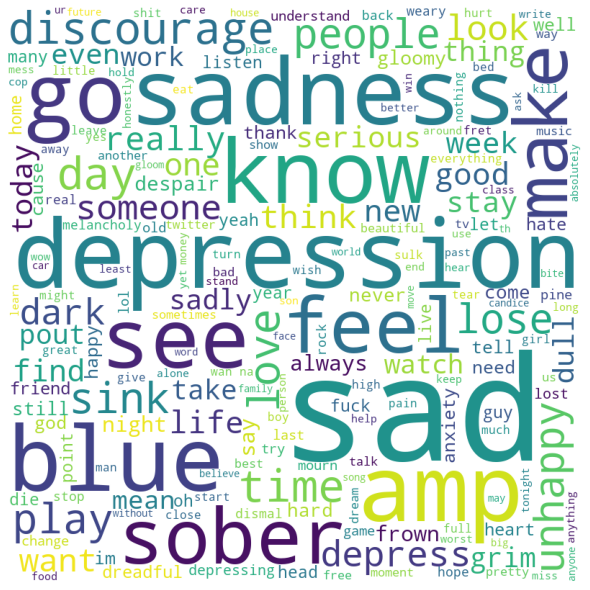

In [82]:
comment_words = ''
for val in test_read['Cleaned Text']:
    comment_words += " ".join(val)+" "

for val in test_read['Hashtags']:
    comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [83]:
#Unique words in Test set
len(comment_words)
li = list(comment_words.split(" "))
x=np.array(li)
len(np.unique(x))

2410

# Text Pre-processing

In [84]:
def join_sent(text):  
    str1 = " "
    return str1.join(text)

In [85]:
train_read['Tweet text']=train_read['Cleaned Text']+train_read['Hashtags']

In [86]:
dev_read['Tweet text']=dev_read['Cleaned Text']+dev_read['Hashtags']

In [87]:
test_read['Tweet text']=test_read['Cleaned Text']+test_read['Hashtags']

In [88]:
train_read['Sentences']=train_read['Tweet text'].apply(join_sent)

In [89]:
train_read.head()

,Index,Tweet,Emotion,Emotion Intensity,Cleaned Text,Hashtags,Tweet text,Sentences
0,40000,Depression sucks! #depression,sadness,0.958,"[depression, suck]",[depression],"[depression, suck, depression]",depression suck depression
1,40001,Feeling worthless as always #depression,sadness,0.958,"[feel, worthless, always]",[depression],"[feel, worthless, always, depression]",feel worthless always depression
2,40002,Feeling worthless as always,sadness,0.958,"[feel, worthless, always]",[],"[feel, worthless, always]",feel worthless always
3,40003,My #Fibromyalgia has been really bad lately wh...,sadness,0.946,"[really, bad, lately, good, mental, state, fee...","[Fibromyalgia, anxiety, bipolar, depression]","[really, bad, lately, good, mental, state, fee...",really bad lately good mental state feel overw...
4,40004,Im think ima lay in bed all day and sulk. Life...,sadness,0.934,"[im, think, ima, lay, bed, day, sulk, life, hi...",[],"[im, think, ima, lay, bed, day, sulk, life, hi...",im think ima lay bed day sulk life hit hard rn


In [90]:
dev_read['Sentences']=dev_read['Tweet text'].apply(join_sent)

In [91]:
test_read['Sentences']=test_read['Tweet text'].apply(join_sent)

In [92]:
def max_len_sent():
  max=0
  for i in train_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_train=max_len_sent()
max_len_train

23

In [93]:
def max_len_sent():
  max=0
  for i in dev_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_dev=max_len_sent()
max_len_dev

18

In [94]:
def max_len_sent():
  max=0
  for i in test_read['Tweet text']:
    if len(i)>max:
      max=len(i)
  return max

max_len_test=max_len_sent()
max_len_test

21

In [95]:
train_read_5 = train_read[train_read['Emotion Intensity'] > 0.5]

In [96]:
dev_read_5 = dev_read[dev_read['Emotion Intensity'] > 0.5]

In [97]:
#test_read_5 = test_read[test_read['Emotion Intensity'] > 0.5]

In [98]:
data_to_list = train_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
train_data = pad_sequences(sequences, maxlen=max_len_train)
print(train_data)

[[  0   0   0 ...  10 380  10]
 [  0   0   0 ... 561  48  10]
 [  0   0   0 ...  12 561  48]
 ...
 [  0   0   0 ...  63 996 143]
 [  0   0   0 ...  64  85 991]
 [  0   0   0 ... 287  13  54]]


In [99]:
data_to_list = dev_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
dev_data = pad_sequences(sequences, maxlen=max_len_dev)
print(dev_data)

[[  0   0   0 ... 127 128  21]
 [  0   0   0 ... 132 133 134]
 [  0   0   0 ... 135  42 136]
 ...
 [  0   0   0 ... 122 468 469]
 [  0   0   0 ...  29 473 474]
 [  0   0   0 ... 481 482 483]]


In [100]:
data_to_list = test_read['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
test_data = pad_sequences(sequences, maxlen=max_len_test)
print(test_data)

[[   0    0    0 ...  483    2  484]
 [   0    0    0 ...   76  483  484]
 [   0    0    0 ...  338   16  339]
 ...
 [   0    0    0 ...  247   95  141]
 [   0    0    0 ...  477 2389  310]
 [   0    0    0 ...   25  311   67]]


In [101]:
y_train = train_read['Emotion Intensity'].to_numpy()
y_train=y_train.reshape(len(train_data),1)

In [102]:
y_dev = dev_read['Emotion Intensity'].to_numpy()
y_dev=y_dev.reshape(len(dev_data),1)

In [103]:
y_test = test_read['Emotion Intensity'].to_numpy()
y_test=y_test.reshape(len(test_data),1)

In [104]:
data_to_list = train_read_5['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
train_data_5 = pad_sequences(sequences, maxlen=max_len_train)
print(train_data_5)

[[   0    0    0 ...    3  178    3]
 [   0    0    0 ...  271   42    3]
 [   0    0    0 ...    8  271   42]
 ...
 [   0    0    0 ... 1460 1461   67]
 [   0    0    0 ... 1464 1465   28]
 [   0    0    0 ...  474 1466 1467]]


In [105]:
data_to_list = dev_read_5['Sentences'].values.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_to_list)
sequences = tokenizer.texts_to_sequences(data_to_list)
dev_data_5 = pad_sequences(sequences, maxlen=max_len_dev)
print(dev_data_5)

[[  0   0   0   0   0   0   0   0   0   0   0  29   2  10  30  31  32  11]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  33  34  35  12  36]
 [  0   0   0   0   0   0   0   0   0   0   0   0  37   2  38  39  40  12]
 [  0   0   0   0   0   0   0   0   0   0   0   0  41  42  43  44  45  46]
 [  0   0   0   0   0   0   0   0   0   0   0   0  11  47  48  49  13  14]
 [  0   0   0   0   0   0   0   0   0   0   0   0   2  50  51   3  52  53]
 [  0   0   0   0   0   0   0   0   0   0   0  54   2  55  15   3  56   4]
 [  0   0   0   0   0   0   0   0   0   0   0  57  58  59  60   5  61   6]
 [  0   0   0   0   0  62  63  64  65  66  67  68  69  70  71  72  73  74]
 [  0   0   0   0   0   0   1  16  75  76  77  78  79  80  81  17  82   4]
 [  0   0   0   0   0   0   0   0   0  83  84   5  85  15  86  87  88  89]
 [  0   0   0   0   0   0  18  90  91  92  93  94  95  96  97  98  99  18]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 100  17 101  19]
 [  0   0   0   0   0   0

In [106]:
#data_to_list = test_read_5['Sentences'].values.tolist()
#tokenizer = Tokenizer(num_words=max_words)
#tokenizer.fit_on_texts(data_to_list)
#sequences = tokenizer.texts_to_sequences(data_to_list)
#test_data_5 = pad_sequences(sequences, maxlen=max_len_test)

In [107]:
y_train_5 = train_read_5['Emotion Intensity'].to_numpy()
y_train_5=y_train_5.reshape(len(train_data_5),1)

In [108]:
y_dev_5 = dev_read_5['Emotion Intensity'].to_numpy()
y_dev_5=y_dev_5.reshape(len(dev_data_5),1)

In [109]:
#y_test_5 = test_read_5['Emotion Intensity'].to_numpy()
#y_test_5=y_test_5.reshape(len(test_data_5),1)

#Generate Embeddings

##Lexicons

In [110]:
lexicon_dict=pd.read_csv("/content/gdrive/MyDrive/EmoInt/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",delimiter = "\t",header=None)


In [111]:
lexicon_dict

,0,1,2
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0
...,...,...,...
141535,zoom,negative,0
141536,zoom,positive,0
141537,zoom,sadness,0
141538,zoom,surprise,0


In [112]:
lexiconDf = pd.DataFrame(columns=['Word','anger','fear','joy','sadness'])

In [113]:
ind=0
coun=0
for i in lexicon_dict.index:
  if ind<len(lexicon_dict):
    lexiconDf.loc[coun,'Word'] =lexicon_dict.loc[lexicon_dict.index[ind]][0]
    lexiconDf.loc[coun,'anger']=lexicon_dict.loc[lexicon_dict.index[ind]][2]
    lexiconDf.loc[coun,'fear']=lexicon_dict.loc[lexicon_dict.index[ind+3]][2]
    lexiconDf.loc[coun,'joy']=lexicon_dict.loc[lexicon_dict.index[ind+4]][2]
    lexiconDf.loc[coun,'sadness']=lexicon_dict.loc[lexicon_dict.index[ind+7]][2]
  else:
    break
  ind += 10
  coun+=1

In [114]:
lexiconDf

,Word,anger,fear,joy,sadness
0,aback,0,0,0,0
1,abacus,0,0,0,0
2,abandon,0,1,0,1
3,abandoned,1,1,0,1
4,abandonment,1,1,0,1
...,...,...,...,...,...
14149,zone,0,0,0,0
14150,zoo,0,0,0,0
14151,zoological,0,0,0,0
14152,zoology,0,0,0,0


In [115]:
def lexicon_avg_train():
  val=[]
  for i in train_read['Tweet text']:
    avg=0
    count=0
    for j in i:
      count=count+1
      qs=lexiconDf[lexiconDf.eq(j).any(1)]
      if (qs.empty)==False:
        avg=avg+int(qs['sadness'])
    avg=avg/count
    val.append(avg)
  return val

lexicon_train_set=lexicon_avg_train()

In [116]:
def lexicon_avg_dev():
  val=[]
  for i in dev_read['Tweet text']:
    avg=0
    count=0
    for j in i:
      count=count+1
      qs=lexiconDf[lexiconDf.eq(j).any(1)]
      if (qs.empty)==False:
        avg=avg+int(qs['sadness'])
    avg=avg/count
    val.append(avg)
  return val

lexicon_dev_set=lexicon_avg_dev()

In [ ]:
def lexicon_avg_test():
  val=[]
  for i in test_read['Tweet text']:
    avg=0
    count=0
    for j in i:
      count=count+1
      qs=lexiconDf[lexiconDf.eq(j).any(1)]
      if (qs.empty)==False:
        avg=avg+int(qs['sadness'])
    avg=avg/count
    val.append(avg)
  return val

lexicon_test_set=lexicon_avg_test()

In [ ]:
textfile = open("/content/gdrive/MyDrive/EmoInt/sadness/file1content.txt", "w")
for element in lexicon_train_set:
    textfile.write(str(element) + "\n")
textfile.close()

In [ ]:
textfile = open("/content/gdrive/MyDrive/EmoInt/sadness/file2content.txt", "w")
for element in lexicon_dev_set:
    textfile.write(str(element) + "\n")
textfile.close()

In [ ]:
textfile = open("/content/gdrive/MyDrive/EmoInt/sadness/file3content.txt", "w")
for element in lexicon_test_set:
    textfile.write(str(element) + "\n")
textfile.close()

In [ ]:
with open('/content/gdrive/MyDrive/EmoInt/sadness/file1content.txt') as f:
    lexicon_train_set = f.read().splitlines()

for i in range(0, len(lexicon_train_set)):
    lexicon_train_set[i] = float(lexicon_train_set[i])

In [ ]:
with open('/content/gdrive/MyDrive/EmoInt/sadness/file2content.txt') as f:
    lexicon_dev_set = f.read().splitlines()

for i in range(0, len(lexicon_dev_set)):
    lexicon_dev_set[i] = float(lexicon_dev_set[i])

In [ ]:
with open('/content/gdrive/MyDrive/EmoInt/sadness/file3content.txt') as f:
    lexicon_test_set = f.read().splitlines()

for i in range(0, len(lexicon_test_set)):
    lexicon_test_set[i] = float(lexicon_test_set[i])

In [ ]:
Xarr1 = np.array(lexicon_train_set)
Xarr1=Xarr1.reshape(len(Xarr1),1)
yarr1 = train_read['Emotion Intensity'].to_numpy()
yarr1=yarr1.reshape(len(Xarr1),1)
lexicon_train=np.hstack((Xarr1,yarr1))

In [ ]:
Xarr2 = np.array(lexicon_dev_set)
Xarr2=Xarr2.reshape(len(Xarr2),1)
yarr2 = dev_read['Emotion Intensity'].to_numpy()
yarr2=yarr2.reshape(len(Xarr2),1)
lexicon_dev=np.hstack((Xarr2,yarr2))

In [ ]:
Xarr3 = np.array(lexicon_test_set)
Xarr3=Xarr3.reshape(len(Xarr3),1)
yarr3 = test_read['Emotion Intensity'].to_numpy()
yarr3=yarr3.reshape(len(Xarr3),1)
lexicon_test=np.hstack((Xarr3,yarr3))

In [ ]:
filter = lexicon_train[:,1]>0.5
lexicon_train_5=lexicon_train[filter]

In [ ]:
filter = lexicon_dev[:,1]>0.5
lexicon_dev_5=lexicon_dev[filter]

In [ ]:
#filter = lexicon_test[:,1]>0.5
#lexicon_test_5=lexicon_test[filter]

## Word2Vec

In [ ]:
from gensim.models import KeyedVectors
filename = '/content/gdrive/MyDrive/EmoInt/GoogleNews-vectors-negative300.bin.gz'
wordmodel = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
pretrained_weights = wordmodel.wv.syn0

In [ ]:
vocab_size, emdedding_size = pretrained_weights.shape

#Evaluation Metrics

In [ ]:
def evaluate(pred_scores,gold_scores,pred_scores_range_05_1,gold_scores_range_05_1):
  pears_corr=stats.pearsonr(pred_scores,gold_scores)[0]
  spear_corr=stats.spearmanr(pred_scores,gold_scores)[0]
  pears_corr_range_05_1=stats.pearsonr(pred_scores_range_05_1,gold_scores_range_05_1)[0]                                    
  spear_corr_range_05_1=stats.spearmanr(pred_scores_range_05_1,gold_scores_range_05_1)[0]       
  return [pears_corr,spear_corr,pears_corr_range_05_1,spear_corr_range_05_1]

#Models

##Statistical Model

### SVM Regression 

In [ ]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [ ]:
y_pred=regr.predict(lexicon_dev[:,1].reshape(-1, 1))

In [ ]:
y_pred_5=regr.predict(lexicon_dev_5[:,1].reshape(-1, 1))

In [ ]:
[pears_corr1,spear_corr1,pears_corr_range_05_11,spear_corr_range_05_11]=evaluate(y_pred,lexicon_dev[:,1],y_pred_5,lexicon_dev_5[:,1])
print('Pearsons correlation for gold score:'+str(pears_corr1))
print('Spearmans correlation for gold score:'+str(spear_corr1))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_11))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_11))

Pearsons correlation for gold score:0.3187902041162276
Spearmans correlation for gold score:0.20634605402721673
Pearsons correlation for gold score for gold score greater than 0.5:0.29051997288262404
Spearmans correlation for gold score for gold score greater than 0.5:0.2712501091989167


### Linear Regression

In [ ]:
reg = LinearRegression().fit(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

In [ ]:
reg.score(lexicon_train[:,0].reshape(-1, 1), lexicon_train[:,1])

0.09373677653088763

In [ ]:
m=reg.coef_
m

array([0.39104982])

In [ ]:
b=reg.intercept_
b

0.4372924896815129

In [ ]:
y_pred=reg.predict(lexicon_dev[:,1].reshape(-1, 1))

In [ ]:
y_pred_5=reg.predict(lexicon_dev_5[:,1].reshape(-1, 1))

In [ ]:
[pears_corr2,spear_corr2,pears_corr_range_05_12,spear_corr_range_05_12]=evaluate(y_pred,lexicon_dev[:,1],y_pred_5,lexicon_dev_5[:,1])
print('Pearsons correlation for gold score:'+str(pears_corr2))
print('Spearmans correlation for gold score:'+str(spear_corr2))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_12))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_12))

Pearsons correlation for gold score:1.0
Spearmans correlation for gold score:1.0
Pearsons correlation for gold score for gold score greater than 0.5:0.9999999999999999
Spearmans correlation for gold score for gold score greater than 0.5:0.9999999999999999


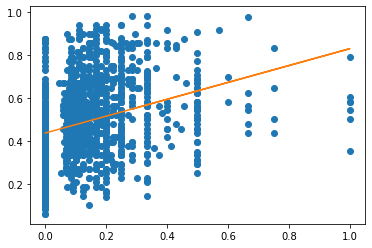

In [ ]:
plt.plot(lexicon_train[:,0], lexicon_train[:,1], 'o')
plt.plot(lexicon_train[:,0], m*lexicon_train[:,0] + b)
plt.show()

## Deep Learning Models

### LSTM

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model1.add(layers.LSTM(15,dropout=0.5)) #Our LSTM layer
model1.add(layers.Dense(3,activation='relu'))
model1.compile(optimizer='adam',loss='mse')

In [ ]:
history = model1.fit(train_data, y_train, epochs=4,batch_size=10,validation_data=(dev_data,y_dev))

Epoch 1/4
36/36 [==============================] - 292s 8s/step - loss: 0.0984 - val_loss: 0.0383
Epoch 2/4
36/36 [==============================] - 304s 8s/step - loss: 0.0367 - val_loss: 0.0367
Epoch 3/4
36/36 [==============================] - 285s 8s/step - loss: 0.0276 - val_loss: 0.0360
Epoch 4/4
36/36 [==============================] - 304s 8s/step - loss: 0.0218 - val_loss: 0.0381


In [ ]:
model1.save("/content/gdrive/MyDrive/EmoInt/sadness/lstm_model")

In [ ]:
model1 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/sadness/lstm_model')

In [ ]:
y_pred = model1.predict(dev_data)

In [ ]:
y_pred_5 = model1.predict(dev_data_5)

In [ ]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [ ]:
[pears_corr3,spear_corr3,pears_corr_range_05_13,spear_corr_range_05_13]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr3))
print('Spearmans correlation for gold score:'+str(spear_corr3))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_13))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_13))

Pearsons correlation for gold score:0.042712472909752865
Spearmans correlation for gold score:0.0519024831557156
Pearsons correlation for gold score for gold score greater than 0.5:0.08929868793270632
Spearmans correlation for gold score for gold score greater than 0.5:0.09770150130163606


### Bidirectional LSTM

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='relu'))
model2.compile(optimizer='adam',loss='mse',)

In [ ]:
history2 = model2.fit(train_data, y_train, epochs=5,validation_data=(dev_data,y_dev))

In [ ]:
model2.save("/content/gdrive/MyDrive/EmoInt/sadness/bidirectional_lstm_model")

In [ ]:
model2 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/sadness/bidirectional_lstm_model')

In [ ]:
y_pred = model2.predict(dev_data)

In [ ]:
y_pred_5 = model2.predict(dev_data_5)

In [ ]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [ ]:
[pears_corr4,spear_corr4,pears_corr_range_05_14,spear_corr_range_05_14]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr4))
print('Spearmans correlation for gold score:'+str(spear_corr4))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_14))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_14))

###1-D Conv Net

In [ ]:
model3 = Sequential()
model3.add(layers.Embedding(input_dim=vocab_size, output_dim=emdedding_size,weights=[pretrained_weights]))
model3.add(layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=2))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(1, activation='relu'))
model3.compile(optimizer='adam',loss='mse')

In [ ]:
history3 = model3.fit(train_data, y_train, epochs=5,validation_data=(dev_data,y_dev))

In [ ]:
model3.save("/content/gdrive/MyDrive/EmoInt/sadness/1ConvNet_model")

In [ ]:
model3 = keras.models.load_model('/content/gdrive/MyDrive/EmoInt/sadness/1ConvNet_model')

In [ ]:
y_pred = model3.predict(dev_data)

In [ ]:
y_pred_5 = model3.predict(dev_data_5)

In [ ]:
y_pred=y_pred[:,0].reshape(dev_data.shape[0],1)
y_pred_5=y_pred_5[:,0].reshape(dev_data_5.shape[0],1)
y_pred = np.squeeze(y_pred)
y_dev = np.squeeze(y_dev)
y_pred_5 = np.squeeze(y_pred_5)
y_dev_5 = np.squeeze(y_dev_5)

In [ ]:
[pears_corr5,spear_corr5,pears_corr_range_05_15,spear_corr_range_05_15]=evaluate(y_pred,y_dev,y_pred_5,y_dev_5)
print('Pearsons correlation for gold score:'+str(pears_corr5))
print('Spearmans correlation for gold score:'+str(spear_corr5))
print('Pearsons correlation for gold score for gold score greater than 0.5:'+str(pears_corr_range_05_15))
print('Spearmans correlation for gold score for gold score greater than 0.5:'+str(spear_corr_range_05_15))

#Results

In [ ]:
d = [ ["SVM Regression with Lexicons", pears_corr1, spear_corr1, pears_corr_range_05_11,spear_corr_range_05_11],
     ["Linear Regression with Lexicons", pears_corr2, spear_corr2, pears_corr_range_05_12,spear_corr_range_05_12],
     ["Word2Vec + LSTM", pears_corr3, spear_corr3, pears_corr_range_05_13,spear_corr_range_05_13]
     ["Word2Vec + Bidirectional LSTM", pears_corr4, spear_corr4, pears_corr_range_05_14,spear_corr_range_05_14]
     ["Word2vec + 1-D Convolutional Network", pears_corr5, spear_corr5, pears_corr_range_05_15,spear_corr_range_05_15]]

print(tabulate(d, headers=["Models", "Pearsons correlation", "Spearsons correlation",'Pearsons correlation with gold score>0.5','Spearsons correlation with gold score>0.5']))